# Introduction
This script performs the following steps:
1. Data Loading, Cleaning, and Exploration:
   - Reads the dataset.
   - Converts date columns and sorts the data.
   - Checks and imputes missing values.
2. Data Aggregation & Visualization:
   - Aggregates the NO2 pollutant values by day.
   - Creates enhanced time series plots, seasonal boxplots, and outlier visualizations.
3. Time Series Analysis:
   - Conducts stationarity tests (ADF) and decomposes the series.
4. Forecasting:
   - Splits data into train and test sets.
   - Uses auto ARIMA for modeling, performs residual diagnostics, and forecasts future values.
   - Evaluates forecast accuracy.
5. Alternative Forecasting with Prophet:
   - Fits a Prophet model and plots its forecast and components.
6. Comparison & Interactive Visualization:
   - Compares ARIMA and Prophet forecasts.
   - Uses Plotly for interactive visualization.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

/opt/homebrew/anaconda3/envs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ====================== 1. Data Loading and Exploration ======================
# Update the file path as needed
data_path = '/Users/enamul/Desktop/Projects/Air_Quality_Index/Data/pollution_us_2000_2016.csv'
df = pd.read_csv(data_path)

----- Data Summary -----
          Unnamed: 0    State Code   County Code      Site Num  \
count   1.746661e+06  1.746661e+06  1.746661e+06  1.746661e+06   
unique           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN   
mean    5.471414e+04  2.230907e+01  7.169381e+01  1.118214e+03   
std     3.372908e+04  1.725621e+01  7.948023e+01  2.003103e+03   
min     0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%     2.575300e+04  6.000000e+00  1.700000e+01  9.000000e+00   
50%     5.304500e+04  1.700000e+01  5.900000e+01  6.000000e+01   
75%     8.033600e+04  4.000000e+01  9.700000e+01  1.039000e+03   
max     1.345750e+05  8.000000e+01  6.500000e+02  9.997000e+03   

                       Address       State       County           City  \
count                  1746661     1746661      1746661        1746661   
unique                     204    

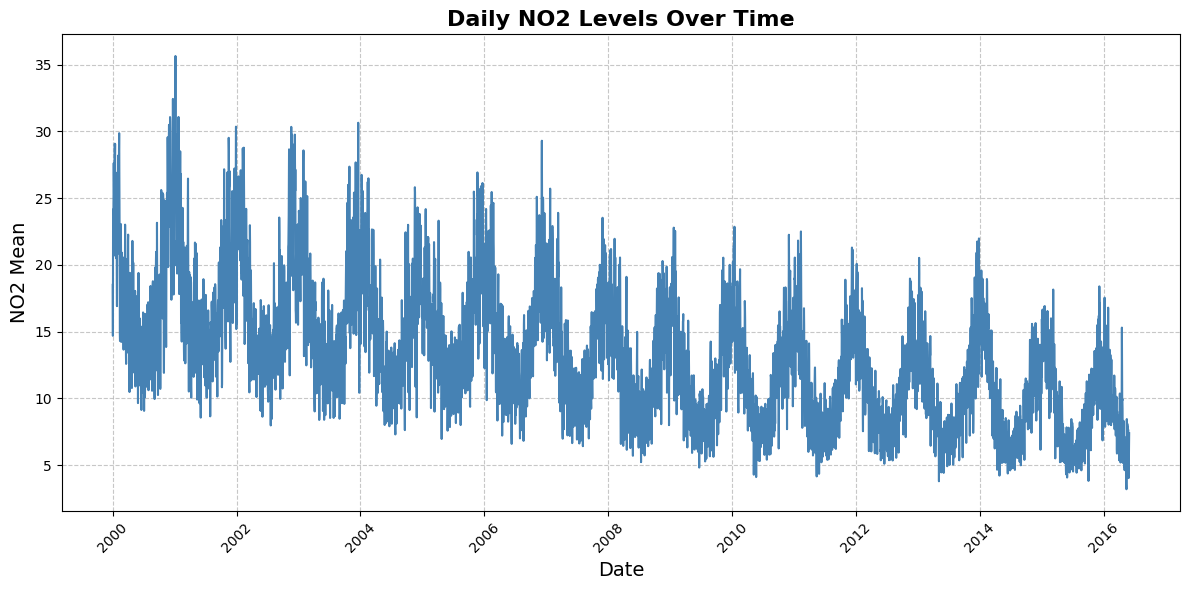

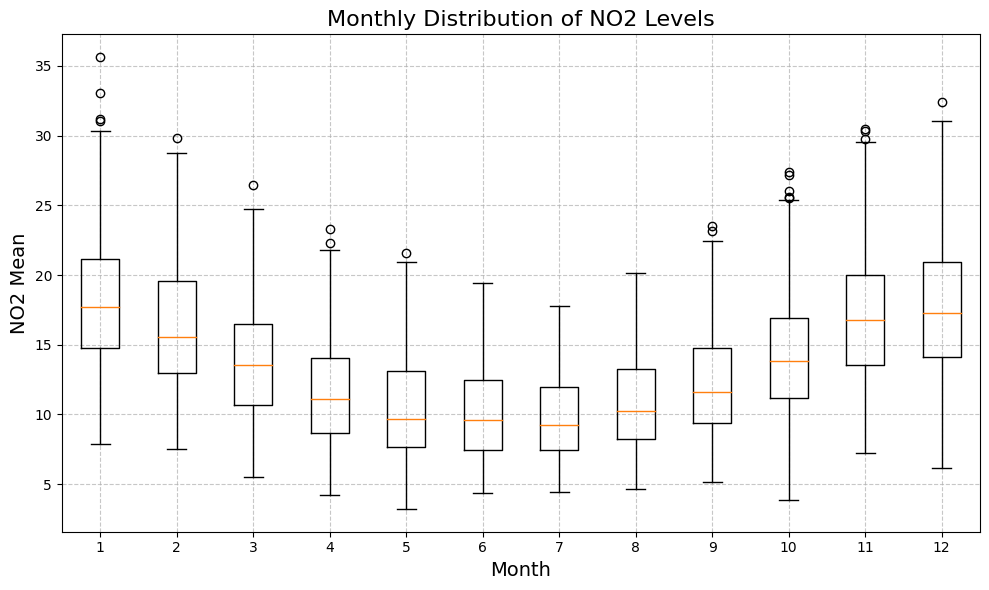


Outlier detection bounds: Lower = -0.6207710257205168 Upper = 26.855927485969005
Number of outliers detected: 75


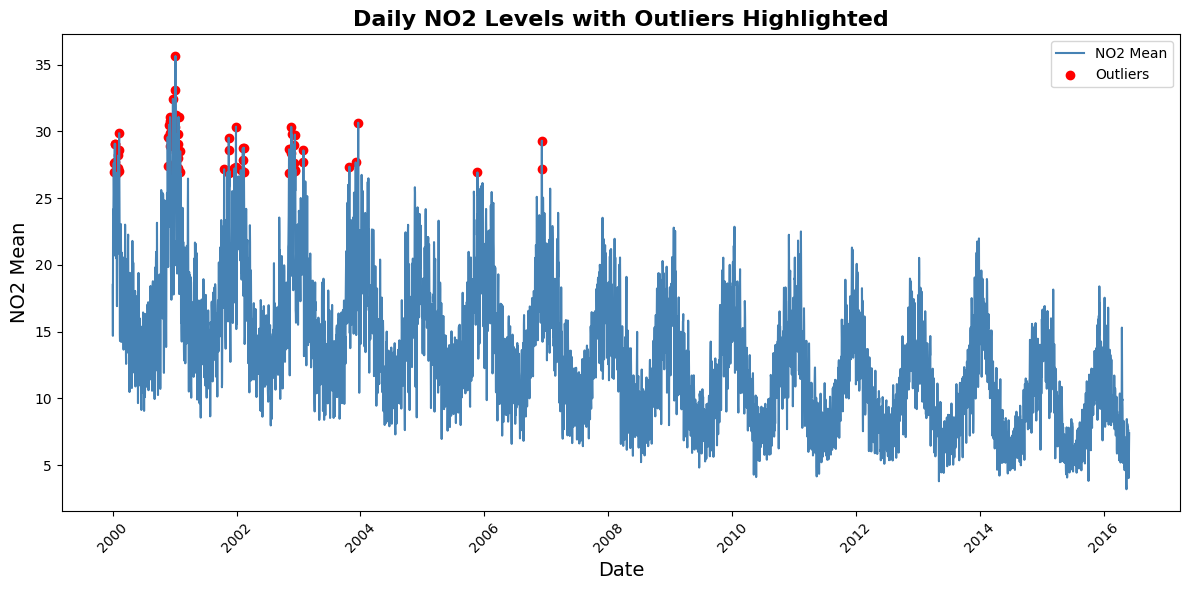

In [3]:
# Convert the date column to datetime and sort
df['Date Local'] = pd.to_datetime(df['Date Local'])

# Set the index to the date column
df.set_index('Date Local', inplace=True)

# Display a summary and missing values per column
print("----- Data Summary -----")
print(df.describe(include='all'))
print("\n----- Missing Values per Column -----")
print(df.isna().sum())

# ====================== 2. Data Cleaning and Imputation ======================
# Ensure NO2.Mean is numeric and impute missing values using time-based interpolation
df['NO2 Mean'] = pd.to_numeric(df['NO2 Mean'], errors='coerce')
df['NO2 Mean'] = df['NO2 Mean'].interpolate(method='time')
print("\nMissing values in NO2 Mean after interpolation:", df['NO2 Mean'].isna().sum())

# ====================== 3. Data Aggregation: Daily Averages ======================
# Aggregate NO2 by day
df_daily = df.groupby('Date Local')['NO2 Mean'].mean().reset_index()

# ====================== 4. Visualization Enhancements ======================
# 4.1 Time Series Plot for Daily NO2 Levels
plt.figure(figsize=(12,6))
plt.plot(df_daily['Date Local'], df_daily['NO2 Mean'], color='steelblue', linewidth=1.5)
plt.title('Daily NO2 Levels Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 Mean', fontsize=14)
plt.xticks(rotation=45)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4.2 Seasonal Box Plot: Monthly Distribution
df_daily['Month'] = df_daily['Date Local'].dt.month
plt.figure(figsize=(10,6))
# Prepare data for each month (1 to 12)
data_by_month = [df_daily[df_daily['Month'] == m]['NO2 Mean'] for m in range(1, 13)]
plt.boxplot(data_by_month, labels=range(1, 13))
plt.title('Monthly Distribution of NO2 Levels', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('NO2 Mean', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4.3 Outlier Detection & Visualization using IQR Method
Q1 = df_daily['NO2 Mean'].quantile(0.25)
Q3 = df_daily['NO2 Mean'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("\nOutlier detection bounds: Lower =", lower_bound, "Upper =", upper_bound)
outliers = df_daily[(df_daily['NO2 Mean'] < lower_bound) | (df_daily['NO2 Mean'] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])

plt.figure(figsize=(12,6))
plt.plot(df_daily['Date Local'], df_daily['NO2 Mean'], color='steelblue', linewidth=1.5, label='NO2 Mean')
plt.scatter(outliers['Date Local'], outliers['NO2 Mean'], color='red', label='Outliers')
plt.title('Daily NO2 Levels with Outliers Highlighted', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 Mean', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


----- ADF Test Results -----
ADF Statistic: -3.4972
p-value: 0.0081
Result: The series is stationary.


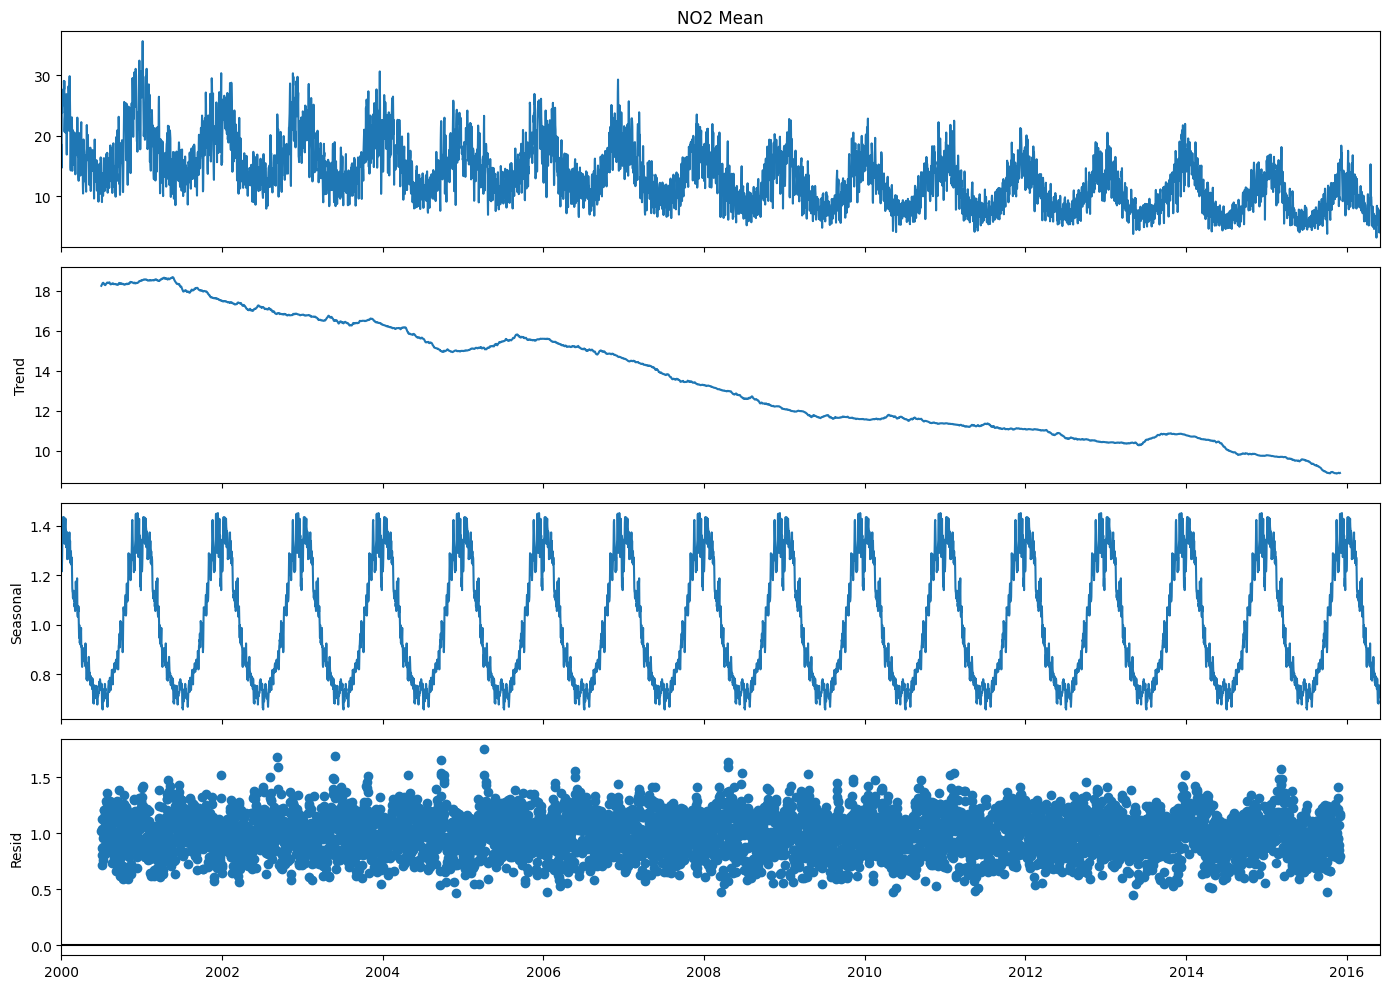

In [4]:
# ====================== 5. Time Series Analysis ======================
# 5.1 Stationarity Test: Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(df_daily['NO2 Mean'])
print("\n----- ADF Test Results -----")
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
if adf_result[1] < 0.05:
    print("Result: The series is stationary.")
else:
    print("Result: The series is non-stationary. Consider differencing.")

# 5.2 Time Series Decomposition (Multiplicative Model)
# Assume an annual seasonality period of 365 days
decomposition = seasonal_decompose(df_daily.set_index('Date Local')['NO2 Mean'], model='multiplicative', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

In [5]:
# ------------------ Data Aggregation ------------------
# Assuming df_daily contains your daily data with columns 'Date Local' and 'NO2 Mean'
# Ensure 'Date Local' is in datetime format
df_daily['Date Local'] = pd.to_datetime(df_daily['Date Local'])

# Aggregate daily data to monthly data by taking the mean
df_monthly = df_daily.set_index('Date Local').resample('M').mean().reset_index()

# ------------------ Train-Test Split on Monthly Data ------------------
# Reserve the last 6 months for testing (you can adjust as needed)
train_monthly = df_monthly.iloc[:-6]
test_monthly = df_monthly.iloc[-6:]
print("\nTrain set period:", train_monthly['Date Local'].min(), "to", train_monthly['Date Local'].max())
print("Test set period:", test_monthly['Date Local'].min(), "to", test_monthly['Date Local'].max())

ts_train_monthly = train_monthly.set_index('Date Local')['NO2 Mean']
ts_test_monthly = test_monthly.set_index('Date Local')['NO2 Mean']


Train set period: 2000-01-31 00:00:00 to 2015-11-30 00:00:00
Test set period: 2015-12-31 00:00:00 to 2016-05-31 00:00:00



----- ARIMA Model Summary (Monthly Data) -----
                                     SARIMAX Results                                     
Dep. Variable:                          NO2 Mean   No. Observations:                  191
Model:             ARIMA(5, 0, 1)x(0, 1, [], 12)   Log Likelihood                -288.733
Date:                           Thu, 06 Mar 2025   AIC                            593.466
Time:                                   01:08:05   BIC                            618.966
Sample:                               01-31-2000   HQIC                           603.806
                                    - 11-30-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0481      0.014     -3.429      0.001      -0.076      -0

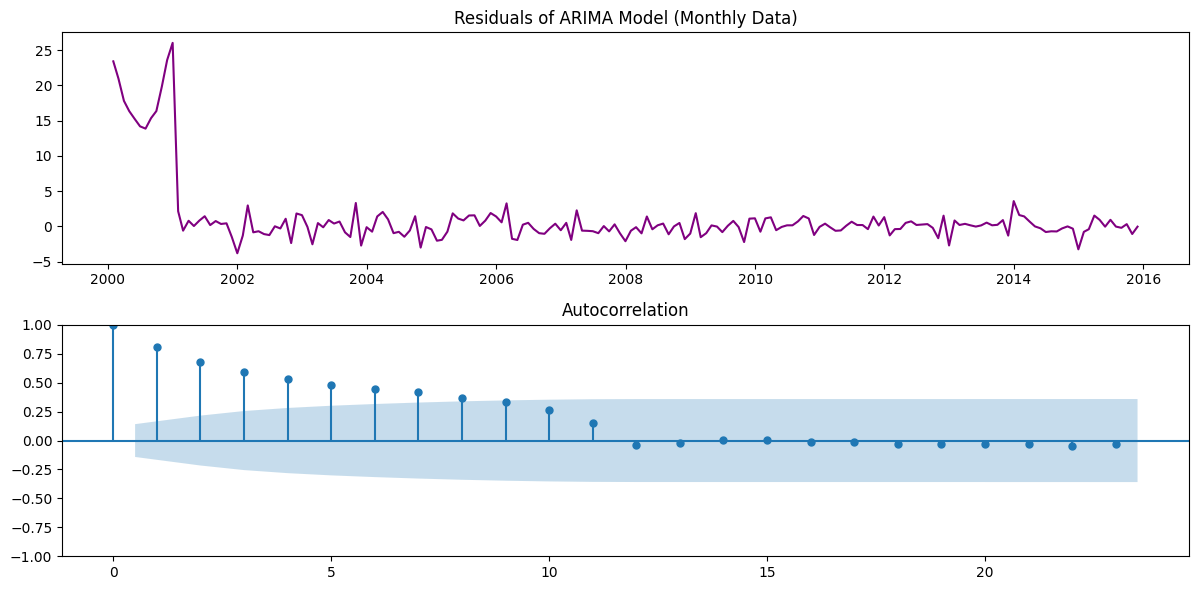


----- Ljung-Box Test Results -----
       lb_stat      lb_pvalue
10  526.102546  1.161082e-106


In [6]:
# ------------------ Manual ARIMA Modeling on Monthly Data ------------------
# Here we use a manual ARIMA specification: order (5,0,1) and seasonal order (0,1,0,12)
# 'trend' is set to 't' to include a linear trend, which is suitable when seasonal differencing (D=1) is applied.
model_monthly = ARIMA(ts_train_monthly, order=(5, 0, 1), seasonal_order=(0, 1, 0, 12), trend='t')
model_fit_monthly = model_monthly.fit()
print("\n----- ARIMA Model Summary (Monthly Data) -----")
print(model_fit_monthly.summary())

# ------------------ Residual Diagnostics ------------------
residuals = model_fit_monthly.resid
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(residuals, color='purple')
plt.title('Residuals of ARIMA Model (Monthly Data)')
plt.subplot(212)
plot_acf(residuals, ax=plt.gca())
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\n----- Ljung-Box Test Results -----")
print(lb_test)

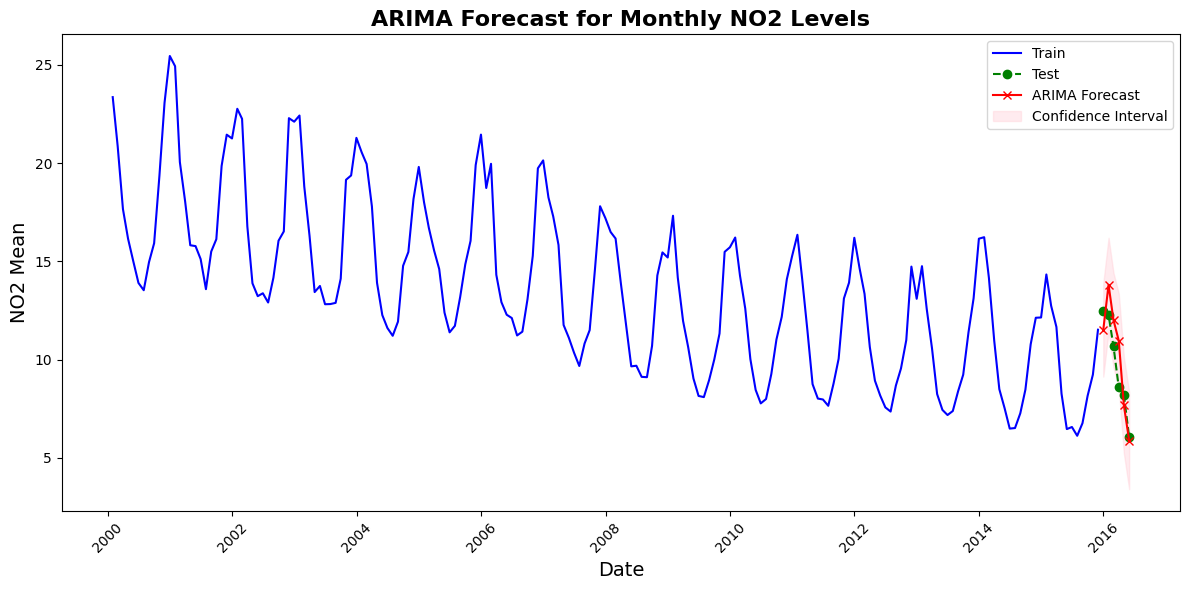


----- ARIMA Forecast Evaluation (Monthly Data) -----
Mean Squared Error: 1.8519268400062423
Mean Absolute Error: 1.1577026565755408


In [7]:
# ------------------ Forecasting with ARIMA ------------------
n_periods = 6  # Forecasting the next 6 months

# Use get_forecast() to obtain a forecast object
forecast_obj = model_fit_monthly.get_forecast(steps=n_periods, alpha=0.05)
forecast_monthly = forecast_obj.predicted_mean
conf_int_monthly = forecast_obj.conf_int(alpha=0.05)

# Generate forecast dates starting from the end of the training data
forecast_dates_monthly = pd.date_range(start=train_monthly['Date Local'].iloc[-1] + pd.offsets.MonthEnd(1), 
                                         periods=n_periods, freq='M')

forecast_df_monthly = pd.DataFrame({
    'Date': forecast_dates_monthly,
    'Forecast': forecast_monthly,
    'Lower CI': conf_int_monthly.iloc[:, 0],
    'Upper CI': conf_int_monthly.iloc[:, 1]
})

plt.figure(figsize=(12,6))
plt.plot(train_monthly['Date Local'], train_monthly['NO2 Mean'], label='Train', color='blue')
plt.plot(test_monthly['Date Local'], test_monthly['NO2 Mean'], label='Test', marker='o', linestyle='--', color='green')
plt.plot(forecast_df_monthly['Date'], forecast_df_monthly['Forecast'], label='ARIMA Forecast', marker='x', color='red')
plt.fill_between(forecast_df_monthly['Date'], forecast_df_monthly['Lower CI'], forecast_df_monthly['Upper CI'],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast for Monthly NO2 Levels', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 Mean', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate forecast performance on monthly data
monthly_mse = mean_squared_error(ts_test_monthly, forecast_monthly)
monthly_mae = mean_absolute_error(ts_test_monthly, forecast_monthly)
print("\n----- ARIMA Forecast Evaluation (Monthly Data) -----")
print("Mean Squared Error:", monthly_mse)
print("Mean Absolute Error:", monthly_mae)

01:08:28 - cmdstanpy - INFO - Chain [1] start processing
01:08:28 - cmdstanpy - INFO - Chain [1] done processing


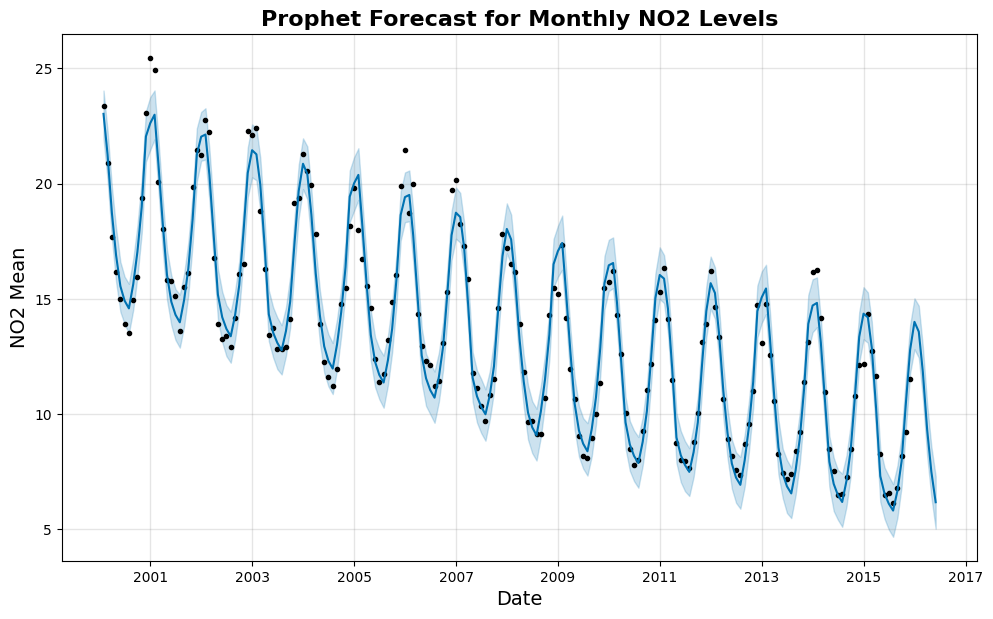

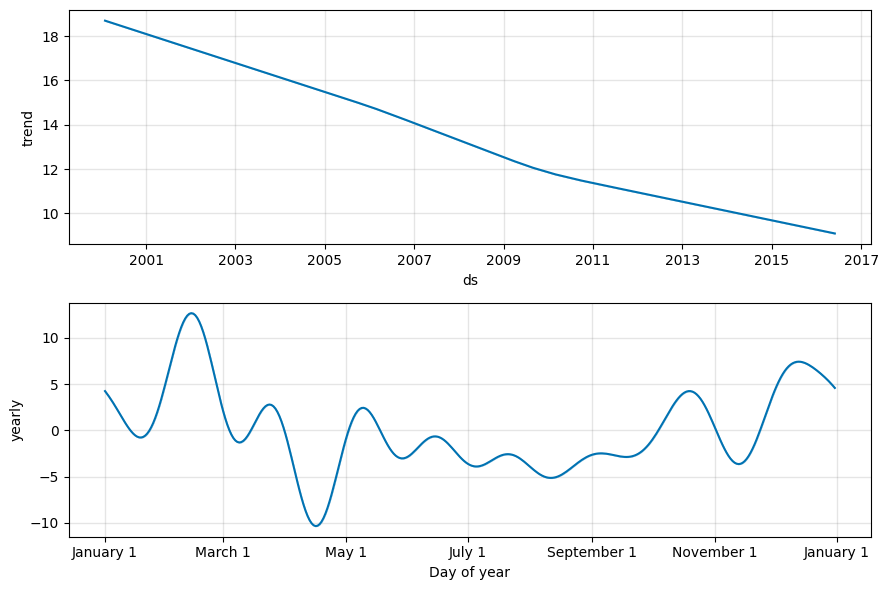

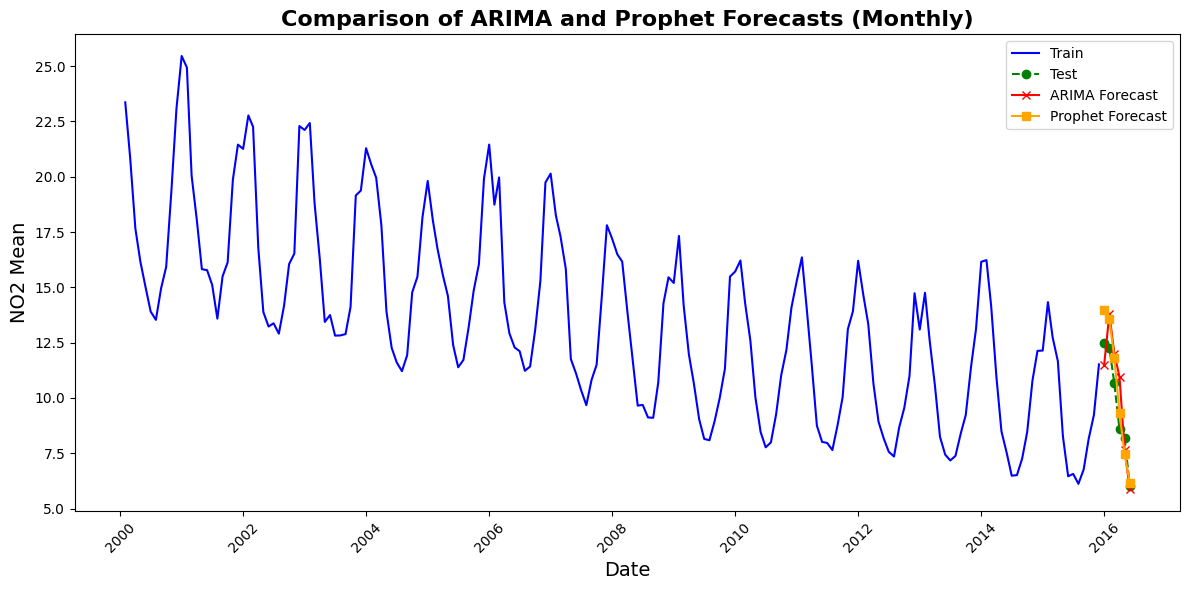

Time series analysis and forecasting project completed successfully!


In [8]:
# ====================== 9. Alternative Forecasting with Prophet (Monthly Data) ======================
# Prepare the data for Prophet using the monthly aggregated data
df_prophet = df_monthly[['Date Local', 'NO2 Mean']].rename(columns={'Date Local': 'ds', 'NO2 Mean': 'y'})

# Split into train and test for Prophet (last 6 months reserved for testing)
train_prophet = df_prophet.iloc[:-6]
test_prophet = df_prophet.iloc[-6:]

# Fit the Prophet model (using yearly seasonality; daily seasonality is disabled)
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(train_prophet)

# Create a dataframe for future dates with monthly frequency (6 months forecast)
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast_prophet = prophet_model.predict(future)

# Plot Prophet forecast
fig_prophet = prophet_model.plot(forecast_prophet)
plt.title('Prophet Forecast for Monthly NO2 Levels', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 Mean', fontsize=14)
plt.show()

# Plot Prophet forecast components (trend, yearly seasonality, etc.)
fig_components = prophet_model.plot_components(forecast_prophet)
plt.show()

# ====================== 10. Comparison of ARIMA and Prophet Forecasts ======================
plt.figure(figsize=(12,6))
plt.plot(train_monthly['Date Local'], train_monthly['NO2 Mean'], label='Train', color='blue')
plt.plot(test_monthly['Date Local'], test_monthly['NO2 Mean'], label='Test', marker='o', linestyle='--', color='green')
plt.plot(forecast_df_monthly['Date'], forecast_df_monthly['Forecast'], label='ARIMA Forecast', marker='x', color='red')
# Extract Prophet forecast for the period covering the test set
prophet_forecast_period = forecast_prophet[forecast_prophet['ds'] >= test_monthly['Date Local'].min()]
plt.plot(prophet_forecast_period['ds'], prophet_forecast_period['yhat'],
         label='Prophet Forecast', marker='s', color='orange')
plt.title('Comparison of ARIMA and Prophet Forecasts (Monthly)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 Mean', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ====================== 11. Interactive Visualization with Plotly ======================
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_monthly['Date Local'], y=train_monthly['NO2 Mean'],
                         mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test_monthly['Date Local'], y=test_monthly['NO2 Mean'],
                         mode='markers+lines', name='Test'))
fig.add_trace(go.Scatter(x=forecast_df_monthly['Date'], y=forecast_df_monthly['Forecast'],
                         mode='lines+markers', name='ARIMA Forecast'))
fig.add_trace(go.Scatter(
    x=forecast_df_monthly['Date'], 
    y=forecast_df_monthly['Lower CI'], 
    mode='lines',
    name='Lower Confidence Interval',
    line=dict(dash='dash')
))
fig.add_trace(go.Scatter(
    x=forecast_df_monthly['Date'], 
    y=forecast_df_monthly['Upper CI'], 
    mode='lines',
    name='Upper Confidence Interval',
    fill='tonexty',
    line=dict(dash='dash')
))
fig.update_layout(
    title='Interactive ARIMA Forecast for Monthly NO2 Levels',
    xaxis_title='Date',
    yaxis_title='NO2 Mean',
    template='plotly_white'
)
fig.show()

# ====================== End of Project ======================
print("Time series analysis and forecasting project completed successfully!")